Notebook to analyze the differences between internal sensors

In [2]:
# Python standard library imports
import time

# Third-party imports for database connection and data manipulation
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
# Third-party imports for mapping
import folium

In [3]:
# Database connection parameters
dbname = 'ar41'
user = 'postgres'
password = '1234'
host = 'localhost'  # localhost or the server address
port = '5432'  # default PostgreSQL port is 5432

# Establish a connection to the database
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_str)

1. Analysis of InAirPC1 and InAirPC2

First of all, we begin by taking a look at the data, considering some constraints:
* We do not consider NULL values (for any of the 2 sensors)
* We do not consider temperatures above 65 (above acceptable boundaries)

What should we consider as an outlier in terms of absolute difference between two sensors? Let's make buckets to analyze it:

In [4]:
query_buckets_inair = f"""
WITH TemperatureDifferences AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        "RS_E_InAirTemp_PC2",
        "RS_E_InAirTemp_PC1",
        ABS("RS_E_InAirTemp_PC2" - "RS_E_InAirTemp_PC1") AS temp_difference
    FROM
        vehicle_data_enriched
    WHERE
        "RS_E_InAirTemp_PC1" IS NOT NULL
        AND "RS_E_InAirTemp_PC1" < 70
        AND "RS_E_InAirTemp_PC2" IS NOT NULL
        AND "RS_E_InAirTemp_PC2" < 70
)
SELECT
    bucket_range,
    COUNT(*) AS occurrences
FROM (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        "RS_E_InAirTemp_PC2",
        "RS_E_InAirTemp_PC1",
        temp_difference,
        floor(temp_difference / 5) * 5 AS bucket_range
    FROM
        TemperatureDifferences
) AS temp_diff_buckets
GROUP BY
    bucket_range
ORDER BY
    bucket_range;
"""

df_buckets_inair = pd.read_sql_query(query_buckets_inair, engine)
print(df_buckets_inair)

    bucket_range  occurrences
0            0.0     10029485
1            5.0      4960690
2           10.0      1630787
3           15.0       527820
4           20.0       208527
5           25.0       108456
6           30.0        67708
7           35.0        47680
8           40.0        30080
9           45.0        13325
10          50.0         6785
11          55.0         3071
12          60.0         1562
13          65.0          962


Following this distribution of data, we choose 40 as the threshold to define an abnormal difference between sensors.

Now let's look at the data, considering what we've discussed before:

In [5]:
query_difference_inair = f"""
SELECT mapped_veh_id, "timestamps_UTC", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2")
FROM vehicle_data_enriched
WHERE "RS_E_InAirTemp_PC1" IS NOT NULL AND "RS_E_InAirTemp_PC2" IS NOT NULL AND "RS_E_InAirTemp_PC1" <= 65 AND "RS_E_InAirTemp_PC2" <= 65
AND ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2") >= 40
ORDER BY ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2") DESC;
"""

df_difference_inair = pd.read_sql_query(query_difference_inair, engine)
print(df_difference_inair)

       mapped_veh_id       timestamps_UTC  RS_E_InAirTemp_PC1  \
0              172.0  2023-02-22 23:01:19                 0.0   
1              168.0  2023-07-28 20:09:00                 0.0   
2              145.0  2023-06-19 19:01:42                65.0   
3              136.0  2023-06-05 20:32:03                 0.0   
4              117.0  2023-06-15 09:54:35                 0.0   
...              ...                  ...                 ...   
51621          194.0  2023-04-17 20:35:50                 0.0   
51622          145.0  2023-04-20 07:59:06                22.0   
51623          168.0  2023-02-18 13:39:52                17.0   
51624          150.0  2023-02-24 12:09:41                25.0   
51625          154.0  2023-02-15 17:23:55                 0.0   

       RS_E_InAirTemp_PC2   abs  
0                    65.0  65.0  
1                    65.0  65.0  
2                     0.0  65.0  
3                    65.0  65.0  
4                    65.0  65.0  
...            

With this data we can observe that there are many timestamps that have one working sensor and the other one on 0, which just means that one sensor is off, and it shouldn't be considered an outlier in terms of difference between PC1 and PC2

With that in mind, we create a new query:

In [6]:
query_difference_inair2 = f"""
SELECT mapped_veh_id, "timestamps_UTC", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2")
FROM vehicle_data_enriched
WHERE "RS_E_InAirTemp_PC1" IS NOT NULL AND "RS_E_InAirTemp_PC2" IS NOT NULL AND "RS_E_InAirTemp_PC1" <= 65 AND "RS_E_InAirTemp_PC2" <= 65 AND ("RS_E_InAirTemp_PC1" != 0 AND "RS_E_InAirTemp_PC2" != 0)
AND ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2") >= 40
ORDER BY ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2") DESC;
"""

df_difference_inair2 = pd.read_sql_query(query_difference_inair2, engine)
print(df_difference_inair2)

       mapped_veh_id       timestamps_UTC  RS_E_InAirTemp_PC1  \
0              159.0  2023-02-13 22:56:38                65.0   
1              162.0  2023-03-08 20:12:26                 6.0   
2              159.0  2023-02-13 22:55:37                65.0   
3              162.0  2023-03-08 20:11:26                 7.0   
4              161.0  2023-01-27 09:29:01                 7.0   
...              ...                  ...                 ...   
19781          142.0  2023-02-23 12:04:06                55.0   
19782          116.0  2023-02-03 12:31:31                52.0   
19783          196.0  2023-03-05 17:44:19                11.0   
19784          192.0  2023-03-11 04:07:21                 7.0   
19785          170.0  2023-03-14 05:35:51                15.0   

       RS_E_InAirTemp_PC2   abs  
0                     6.0  59.0  
1                    65.0  59.0  
2                     7.0  58.0  
3                    65.0  58.0  
4                    65.0  58.0  
...            

Now we have around 20,000 values that could be considered outliers. Now let's take a look at the trains that normally have this case happening:

[]

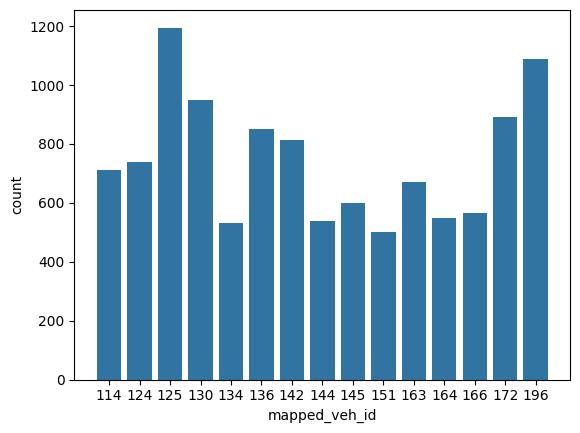

In [7]:
query_difference_inair3 = f"""
WITH absdiffinair AS (
    SELECT mapped_veh_id, "timestamps_UTC", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2")
    FROM vehicle_data_enriched
    WHERE "RS_E_InAirTemp_PC1" IS NOT NULL AND "RS_E_InAirTemp_PC2" IS NOT NULL AND "RS_E_InAirTemp_PC1" <= 65 AND "RS_E_InAirTemp_PC2" <= 65 AND ("RS_E_InAirTemp_PC1" != 0 AND "RS_E_InAirTemp_PC2" != 0)
    AND ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2") >= 40
    ORDER BY ABS("RS_E_InAirTemp_PC1"-"RS_E_InAirTemp_PC2") DESC
)
SELECT mapped_veh_id, count(*)
FROM absdiffinair
GROUP BY mapped_veh_id
ORDER BY count(*) DESC;
"""

df_difference_inair3 = pd.read_sql_query(query_difference_inair3, engine)

#Keep only trains with more than 500 cases
df_difference_inair3 = df_difference_inair3[df_difference_inair3['count']>500]
df_difference_inair3['mapped_veh_id'] = df_difference_inair3['mapped_veh_id'].astype(int)

sns.barplot(x='mapped_veh_id', y='count', data=df_difference_inair3)
plt.plot()


Now the question is: are this ocurrences happening at different times of the year, or during an extended continous period?

If the sensors eventually return to have normal differences, should we care about these differences? Probably not

So let's make a query to understand differences that persist over a long period of time:
* This query looks for continous differences of more than 40°C in the same train, and makes groups
* We can see the starting and ending timestamps, the count of timestamps considered and the duration in minutes

In [14]:
query_difference_inair4 = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_E_InAirTemp_PC1",
        "RS_E_InAirTemp_PC2",
        ABS("RS_E_InAirTemp_PC1" - "RS_E_InAirTemp_PC2") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp
    FROM
        vehicle_data_enriched
    WHERE
        "RS_E_InAirTemp_PC1" IS NOT NULL
        AND "RS_E_InAirTemp_PC2" IS NOT NULL
        AND "RS_E_InAirTemp_PC1" <= 65
        AND "RS_E_InAirTemp_PC2" <= 65
        AND ("RS_E_InAirTemp_PC1" != 0 AND "RS_E_InAirTemp_PC2" != 0)
        AND ABS("RS_E_InAirTemp_PC1" - "RS_E_InAirTemp_PC2") >= 40
)
, grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
)
SELECT
    mapped_veh_id,
    new_group AS group,
    COUNT(*) AS count,
    MIN("timestamps_UTC") AS starting_timestamp,
    MAX("timestamps_UTC") AS ending_timestamp,
    EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
FROM
    grouped_data
GROUP BY
    mapped_veh_id,
    new_group
HAVING
    COUNT(*) > 1
ORDER BY
    duration_minutes DESC;
"""

df_difference_inair4 = pd.read_sql_query(query_difference_inair4, engine)
print(df_difference_inair4)
df_difference_inair4.to_csv('InAirSensorDiff.csv', sep=',', index=False, encoding='utf-8')


     mapped_veh_id  group  count  starting_timestamp    ending_timestamp  \
0            125.0      1    592 2023-01-23 08:29:46 2023-01-23 13:40:45   
1            196.0      1    404 2023-03-05 17:37:09 2023-03-05 21:00:04   
2            136.0     11    287 2023-02-21 21:22:20 2023-02-21 23:51:28   
3            168.0     10    283 2023-03-31 10:03:11 2023-03-31 12:31:18   
4            163.0      8    256 2023-02-20 21:28:55 2023-02-20 23:49:24   
..             ...    ...    ...                 ...                 ...   
868          173.0      3      2 2023-02-09 04:04:31 2023-02-09 04:04:32   
869          128.0      6      2 2023-04-28 20:34:14 2023-04-28 20:34:15   
870          142.0     46      2 2023-05-19 13:23:23 2023-05-19 13:23:24   
871          142.0     42      2 2023-04-18 19:28:07 2023-04-18 19:28:08   
872          181.0      3      2 2023-02-07 07:09:48 2023-02-07 07:09:49   

     duration_minutes  
0          310.983333  
1          202.916667  
2          149.

There are many groups of consecutive temperature differences that go on for more than 2 hours, which is something strange considering that we are excluding the records when either one of the sensors is off.

The average duration of this absolute difference is of 13 minutes.

Now let's make a query so we can see the original records belonging to a group that has temperature differences for more than the average duration (13 minutes):

In [12]:
query_difference_inair5 = f"""
WITH selected_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC"::TIMESTAMP,
        "RS_E_InAirTemp_PC1",
        "RS_E_InAirTemp_PC2",
        ABS("RS_E_InAirTemp_PC1" - "RS_E_InAirTemp_PC2") AS temp_difference,
        LAG("timestamps_UTC"::TIMESTAMP) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS prev_timestamp,
        lat,
        lon,
        "RS_E_OilPress_PC1",
        "RS_E_OilPress_PC2",
        rs_e_rpm_pc1,
        rs_e_rpm_pc2,
        "RS_E_WatTemp_PC1",
        "RS_E_WatTemp_PC2",
        "RS_T_OilTemp_PC1",
        "RS_T_OilTemp_PC2",
        timestamps_floor,
        nearest_point_id,
        "Lat",
        "Lon",
        "Time",
        "Temperature",
        "Humidity",
        "Rain"
    FROM
        vehicle_data_enriched
    WHERE
        "RS_E_InAirTemp_PC1" IS NOT NULL
        AND "RS_E_InAirTemp_PC2" IS NOT NULL
        AND "RS_E_InAirTemp_PC1" <= 65
        AND "RS_E_InAirTemp_PC2" <= 65
        AND ("RS_E_InAirTemp_PC1" != 0 AND "RS_E_InAirTemp_PC2" != 0)
        AND ABS("RS_E_InAirTemp_PC1" - "RS_E_InAirTemp_PC2") >= 40
),
grouped_data AS (
    SELECT
        mapped_veh_id,
        "timestamps_UTC",
        temp_difference,
        SUM(CASE WHEN "timestamps_UTC" - prev_timestamp > INTERVAL '10' MINUTE OR prev_timestamp IS NULL THEN 1 ELSE 0 END) OVER (PARTITION BY mapped_veh_id ORDER BY "timestamps_UTC") AS new_group
    FROM
        selected_data
)
, group_durations AS (
    SELECT
        mapped_veh_id,
        new_group AS group,
        MIN("timestamps_UTC") AS starting_timestamp,
        MAX("timestamps_UTC") AS ending_timestamp,
        EXTRACT(EPOCH FROM (MAX("timestamps_UTC") - MIN("timestamps_UTC"))) / 60 AS duration_minutes
    FROM
        grouped_data
    GROUP BY
        mapped_veh_id, new_group
    HAVING
        COUNT(*) > 1
)
, average_duration AS (
    SELECT
        AVG(duration_minutes) AS avg_duration
    FROM
        group_durations
)
SELECT
    sd.mapped_veh_id,
    sd."timestamps_UTC" AS timestamp,
    sd."RS_E_InAirTemp_PC1",
    sd."RS_E_InAirTemp_PC2",
    sd.temp_difference,
    sd.lat,
    sd.lon,
    sd."RS_E_OilPress_PC1",
    sd."RS_E_OilPress_PC2",
    sd.rs_e_rpm_pc1,
    sd.rs_e_rpm_pc2,
    sd."RS_E_WatTemp_PC1",
    sd."RS_E_WatTemp_PC2",
    sd."RS_T_OilTemp_PC1",
    sd."RS_T_OilTemp_PC2",
    sd.timestamps_floor,
    sd.nearest_point_id,
    sd."Lat",
    sd."Lon",
    sd."Time",
    sd."Temperature",
    sd."Humidity",
    sd."Rain"
FROM
    selected_data sd
JOIN
    grouped_data gd ON sd.mapped_veh_id = gd.mapped_veh_id AND sd."timestamps_UTC" = gd."timestamps_UTC"
JOIN
    group_durations gdd ON gd.mapped_veh_id = gdd.mapped_veh_id AND gd.new_group = gdd.group
JOIN
    average_duration ad ON 1=1
WHERE
    gdd.duration_minutes > ad.avg_duration
ORDER BY
    sd.mapped_veh_id,
    sd."timestamps_UTC";
"""

df_difference_inair5 = pd.read_sql_query(query_difference_inair5, engine)
df_difference_inair5['outlier_flag'] = 'Outside Temperature'
print(df_difference_inair5)
df_difference_inair5.to_csv('R10-1.csv', sep=',', index=False, encoding='utf-8')


       mapped_veh_id           timestamp  RS_E_InAirTemp_PC1  \
0              102.0 2023-04-26 23:43:58                58.0   
1              102.0 2023-04-26 23:44:08                58.0   
2              102.0 2023-04-26 23:44:57                58.0   
3              102.0 2023-04-26 23:45:08                58.0   
4              102.0 2023-04-26 23:45:58                58.0   
...              ...                 ...                 ...   
14822          197.0 2023-04-03 07:10:52                64.0   
14823          197.0 2023-04-03 07:11:50                64.0   
14824          197.0 2023-04-03 07:11:51                64.0   
14825          197.0 2023-04-03 07:12:50                64.0   
14826          197.0 2023-04-03 07:12:52                64.0   

       RS_E_InAirTemp_PC2  temp_difference        lat       lon  \
0                    17.0             41.0  51.016234  3.772886   
1                    17.0             41.0  51.016019  3.773479   
2                    15.0     

And with that, we can conclude the analysis. There are ~15000 values that have a strange continous difference between their internal air temperature sensors.